In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr

# Interpolation in temperature

In [2]:
#Import idealgas module
from thermoextrap.xtrapy import idealgas

## Classes used for interpolation

Instead of performing extrapolation, we can also perform interpolation. Classes already exist for this, namely `ExtrapWeightedModel`, `InterpModel`, and `MBARModel`. The first implements extrapolation from two points weighted with a Minkowski-like distance, the second polynomial interpolation from any number of points, and the last uses reweighting with MBAR from multiple points.

Demonstrations of creating and using `InterpModel` and `MBARModel` classes are shown below.

In [3]:
from thermoextrap import xtrapy
from thermoextrap.xtrapy import xpan_beta
from thermoextrap.xtrapy import recursive_interp

The `InterpModel` will essentially just stitch together muliple `ExtrapModel` objects generated at multiple $\beta$ values by `xpan_beta.factory_extrapmodel`. The `InterpModel` class is actually based on a very general and helpful class called `StateCollection`, which just holds a list of `ExtrapModel` objects. `InterpModel` just uses this list of objects in a specific way to implement piecewise polynomial interpolation.

The functions below conveniently pull a specified number of $\beta$ values out of a range and create `ExtrapModel` objects for each $\beta$ value in a provided list. These will be very convenient as we generate data and models at different states.

In [4]:
def get_betas(nbeta=4, betamin=0.1, betamax=10.0):
    dbeta = (betamax - betamin) / (nbeta-1)
    return np.array([betamin + dbeta * i for i in range(nbeta)])
    
def get_xems(betas, nconfig=100000, npart=1000, order=2, vol=1):
    xems = []
    for beta in betas:
        xdata, udata = idealgas.generate_data((nconfig, npart), beta=beta, vol=vol)
        xem = xpan_beta.factory_extrapmodel(beta=beta,
                                            data=xpan_beta.DataCentralMomentsVals.from_vals(
                                                xv=xdata, uv=udata, central=True, order=order))
        xems.append(xem)

    return xems
    


In [5]:
#Define a range of beta values to test predictions at
betas = np.arange(0.1, 10.0, 0.5)

#Grab betas from either end, as well as data and ExtrapModel objects at reference betas
beta_samp = get_betas(2)
xems = get_xems(beta_samp)

#Create models
xemi = xtrapy.InterpModel(xems)
xmbar = xtrapy.MBARModel(xems)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jim2/bin/miniforge3/envs/thermoextrap-env/lib/python3.8/site-packages/pymbar/mbar.py:1202: RuntimeWarning: invalid value encountered in sqrt
  result_vals['sigma'] = np.sqrt(covA_ij[0:I,0:I].diagonal())


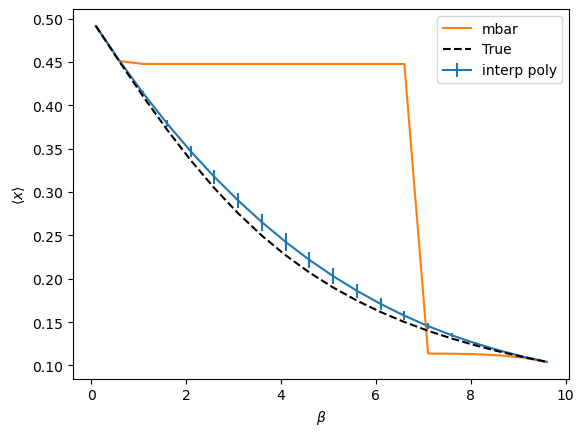

In [6]:
#Make rpedictions with each type of interpolative model

fig, ax = plt.subplots()

out = xemi.predict(betas, order=1)
err = xemi.resample(nrep=100).predict(betas, order=2).std('rep')
plt.errorbar(betas, out, yerr=err, label='interp poly')

xmbar.predict(betas).plot(label='mbar')

#And plot the true values
plt.plot(betas, idealgas.x_ave(betas), 'k--', label='True', zorder=3)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle x \rangle$')
ax.legend()


The above compares polynomial interpolation and MBAR (really just BAR because using only 2 points). Both methods are used to interpolate between the two extreme values of beta. In both cases, the same data from the two edge points is used, making use of only derivatives up to 1st order for interpolation. The error bars are one standard deviation from bootstrap resampling of the predictions of each model. True values are represented by the black dashed line.

We don't really expect MBAR to do any better than perturbation because it is using the MBAR weights between states to reweight the perturbation theory estimates. As such, we can see that it is "sticky" in that it tries to keep using a single point until it suddenly jumps to the next one. This is a symptom of the fact that the perturbation theory estimates themselves plateau. Such plateaus represent poor overlap, resulting in large free energy differences and MBAR weights that essentially act as step functions (i.e. you just pick whichever point has lower free energy over the entire interval). Extrapolation is almost always better, but note that it's predictions vary more with sampling, especially if you go to higher order.

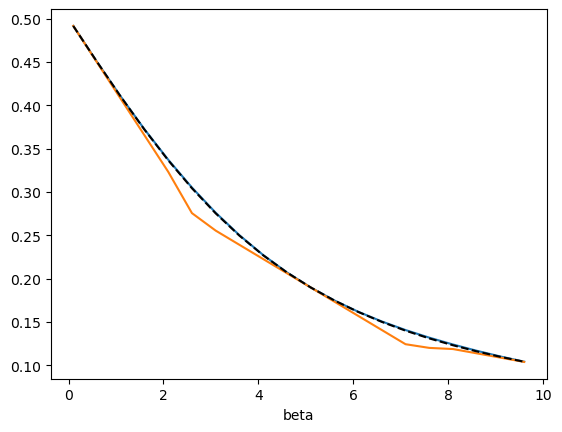

In [7]:
# Adding an additional reference beta value
betas_samp = get_betas(3)
xems = get_xems(betas_samp)

xemi = xtrapy.InterpModel(xems)
xemi.predict(betas, order=1).plot()

xemw = xtrapy.ExtrapWeightedModel(xems)
xemw.predict(betas, order=1).plot()

plt.plot(betas, idealgas.x_ave(betas), 'k--', label='True', zorder=3)

## Recursive interpolation

Also included in the library is a function to perform recursive interpolation to achieve estimates over an interval to a specified error tolerance. The model class that does this is called `RecursiveInterp`. One of the inputs to this class is an interpolation class object (trained or not), such as `InterpModel`. This function continues picking new points and dividing the original interval until all points satisfy the error tolerance, which is represented as a relative error. Details of the algorithm are provided below.

A key feature of `RecursiveInterp` is a method called `getData`. Simply put, this obtains data if provided a value of the variable over which we're extrapolating. By default, this method is just set up to return data at a specified $\beta$ for the 1D ideal gas model, so we don't need to touch it. However, in the paper we modify this method to load in data from an MD simulation of water closest to the specified state point. If you want to generate new MD or MC data on the fly, you will need to create a new class that inherits from `RecursiveInterp` and just change the `getData` method to run the appropriate simulation and load in the data you need.


Interpolating from points 0.100000 and 9.600000
Recursion depth on this branch: 0
Maximum bootstrapped error within interval: 0.006693
Selected new extrapolation point: 4.753061


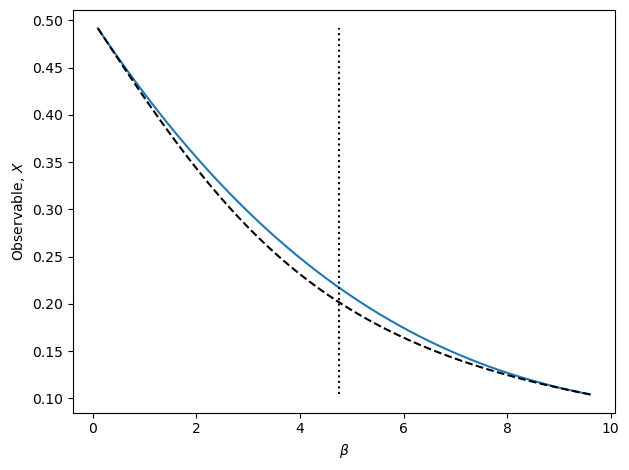


Interpolating from points 0.100000 and 4.753061
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.002329
No additional extrapolation points necessary on this interval.


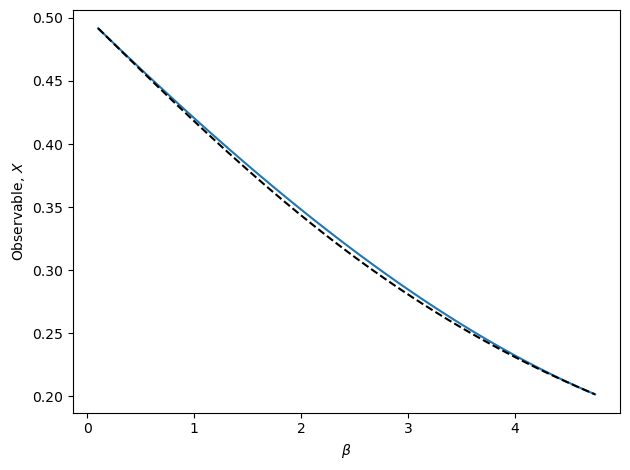


Interpolating from points 4.753061 and 9.600000
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.002455
No additional extrapolation points necessary on this interval.


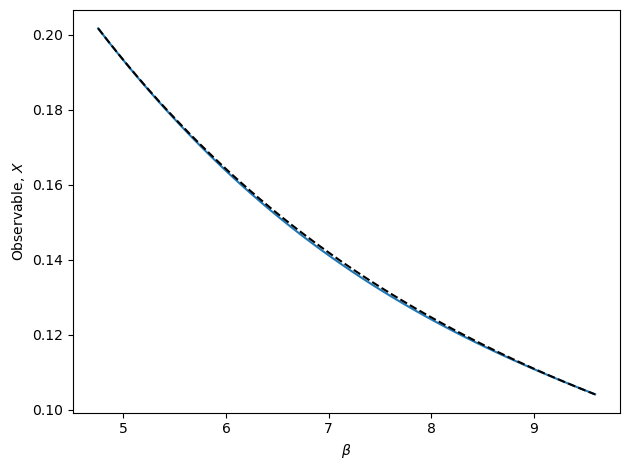

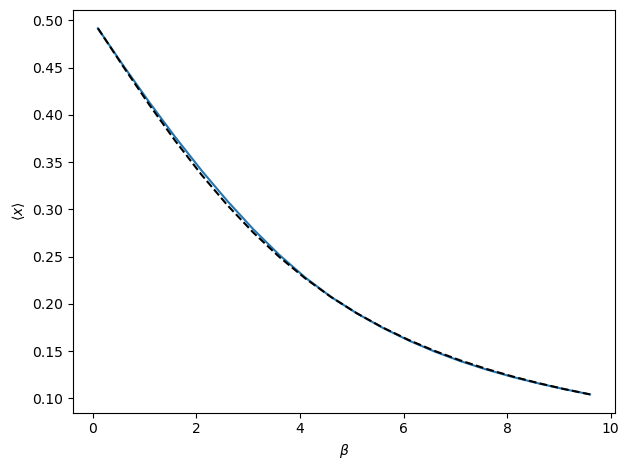

In [9]:
#Generate coefficients
derivs = xpan_beta.factory_derivatives()

#Create the recursive model
intPpiecewise = xtrapy.recursive_interp.RecursiveInterp(xtrapy.InterpModel, derivs,
                                                        [betas[0], betas[-1]],
                                                        maxOrder=1, errTol=0.003)

#Train it recursively until error tolerance reached
#Turn off verbose or doPlot if don't want to see progress of algorithm
#plotCompareFunc provides the true values to compare to in the figure
np.random.seed(42)
intPpiecewise.recursiveTrain(betas[0], betas[-1], verbose=True, doPlot=True, plotCompareFunc=idealgas.x_ave)

#Obtain predictions from our model, which will be based on piecewise interpolating polynomials
intPpredict = intPpiecewise.predict(betas)

#Plot to compare against true average versus beta for ideal gas model
plt.ion()
interpFig, interpAx = plt.subplots()

interpAx.plot(betas, intPpredict)
interpAx.plot(betas, idealgas.x_ave(betas), 'k--', zorder=3)

interpAx.set_ylabel(r'$\langle x \rangle$')
interpAx.set_xlabel(r'$\beta$')

interpFig.tight_layout()

plt.show()


The above cell runs an automated algorithm for performing interpolation recursively. In the above example, polynomial interpolation is used. This is recommended, but the algorithm may also use weighted extrapolation or MBAR. In the figure, the true observable is shown as the dashed black line. The blue line is final result of the recursive algorithm. Note that there is no bootstrap method for `RecursiveInterp` since the algorithm guarantees the uncertainty to be within the tolerance.

A sketch of the recursive algorithm is as follows:

1. Perform interpolation between edge points
    * Only uses up to maximum desired order of derivative information. In the simple ideal gas model, it requires prohibitive amounts of sampling to get good accuracy of derivatives above order 2. If using polynomial interpolation, 2nd derivatives will give us order 5 polynomials. In practice, this probably isn't necessary, so settling for the much more accurate 3rd order interpolating polynomials, which only make use of 1st derivatives.
    * Needs input data at each edge point or must modify getData method in the RecursiveInterp class to read in data or perform simulations. As a default, this class just uses the toy ideal gas model to generate data.
  
  
2. Calculate bootstrapped uncertainty over whole interval
    * The region between the edge points is gridded up with the interpolation model used to predict the value at each point. This procedure is bootstrapped by resampling the data to get the standard deviation of each predicted value at each grid point. The absolute relative error is defined as $\frac{\sigma_x}{|x|}$. The maximum relative error over all grid points and observable elements (if the observable is a vector) is found and compared to the desired tolerance. 
  
  
3. Check if maximum uncertainty is within tolerance
    * If the maximum absolute relative error within the region is lower than the tolerance, then no new simulations are needed. If it is larger than the tolerance, a new state-point is selected where the absolute relative error is a maximum.
  
  
4. Add state point if necessary and recurse
    * If the tolerance is not met, a state point is added as described above. The algorithm returns to step one for each subinterval created, with new data only generated at the new point.


Though the algorithm has met the specified tolerance, you may still want to manually add more points. This is easy with the `sequentialTrain` method.

In [10]:
intPpiecewise.sequentialTrain([2.5, 7.5], verbose=True)


Interpolating from points 0.100000 and 2.500000
Maximum bootstrapped error within interval: 0.001113
At point: 1.373469

Interpolating from points 2.500000 and 4.753061
Maximum bootstrapped error within interval: 0.001089
At point: 3.419617

Interpolating from points 4.753061 and 7.500000
Maximum bootstrapped error within interval: 0.001338
At point: 5.762141

Interpolating from points 7.500000 and 9.600000
Maximum bootstrapped error within interval: 0.000677
At point: 8.271429


It is a good idea when using the recursive algorithm to visually check for consistency.

Interval with edges [0.1        2.5        4.75306122] (indices [0 1 2]):
	P-values between regions:
[0.97861807 0.99906219 0.99999415 0.99999895]
	P-values for full and 1 :
[0.09494636 0.21505965 0.97540201 0.99702904]
	P-values for full and 2 :
[0.97846345 0.99887668 0.99977972 0.999881  ]
Interval with edges [2.5        4.75306122 7.5       ] (indices [1 2 3]):
	P-values between regions:
[0.37553362 0.41727297 0.41871656 0.38826451]
	P-values for full and 1 :
[0.17878952 0.21222505 0.24692956 0.26307335]
	P-values for full and 2 :
[0.31759552 0.3551746  0.37580741 0.38622669]
Interval with edges [4.75306122 7.5        9.6       ] (indices [2 3 4]):
	P-values between regions:
[0.98118809 0.98372184 0.98256629 0.97612887]
	P-values for full and 1 :
[0.43490486 0.47822385 0.5180128  0.53958755]
	P-values for full and 2 :
[0.97542167 0.9798468  0.98230479 0.98357373]


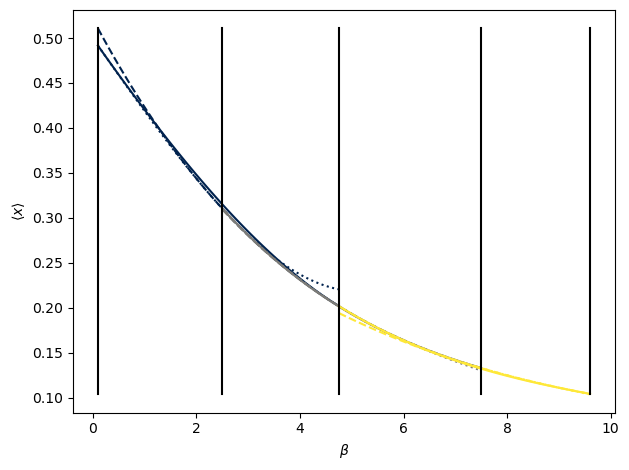

In [11]:
#Can also check for consistency of local curvature
#Not implemented as an "optimization" rule in the recursive interpolation procedure
#But do have function to do statistical and visual check

#Using the model we just trained above, so must run cell above before this one
checkPvals = intPpiecewise.checkPolynomialConsistency(doPlot=True)

In the above plot, interpolating polynomials are shown for sliding windows of three state points used in the recursive interpolation model. Colors change for each window. Within a window (same color) the interpolating polynomial for the lower subregion is shown with a dotted line, that for the upper subregion with a dashed line, and the whole window region using the two outermost edge points with a solid line. Outside of the region they were fitted over, the polynomials show large deviations from the true values. For interpolation, however, the polynomials all overlap quite well. By construction, the piecewise function created by the recursive procedure is continuous in both its value and first derivative at all points in the entire interval. Using higher order derivative information would result in continuity in even higher derivatives, but likely even more divergent behavior outside of the interpolated range.

The point of the above consistency check is to see if the local polynomials agree within each sliding window. If they do, then that means the local curvature is the same over that region and is captured by the order of polynomial that is fit there. To this end, the polynomial coefficients are also boostrapped and, assuming Normal distributions, p-values are computed for the null hypothesis that the coefficients for each set of sub-regions and the full region within a window are the same. Since we want the polynomials to be the same, we don't want small p-values, so the test is of limited usefulness as larger p-values don't necessarily imply greater similarity. A better statistical test is thus needed. However, the visualization provides a quick visual check/rule of thumb to gauge the consistency of the local curvature and thus convergence of the algorithm. This is similar to the idea of generating overlapping distributions for umbrella sampling.